In [90]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from skimage.filters import sobel
from skimage.feature import graycomatrix, graycoprops
import os

# Proceso de Entrenamiento
## Parte 1: Agregar las imágenes a un arreglo
### En cuadernos de notas anteriores se realizó el proceso de preprocesamiento de datos necesario para poder aislar lo mayor posible al cerebro del resto del tejido circundante. Con las imágenes ya preprocesadas, estas pasan a la siguiente parte del pipeline. Estas imágenes serán convertidas a formato de openCV para que puedan ser leídas con facilidad. Este arreglo será transformado a un dataframe en los últimos pasos del pipeline.

In [91]:
train_images = [] #Inicializar arreglos en cero
train_labels = [] 

test_images = []
test_labels = []

from pathlib import Path

path_train = Path("datasets/brain-tumor-mri-datasets/Training")
path_test = Path("datasets/brain-tumor-mri-datasets/Testing")

#Labels de entrenamiento
for label in os.listdir(path_train):
    for img in os.listdir(os.path.join(path_train,label)):
        image = cv2.imread(os.path.join(path_train,label,img),0)
        train_images.append(image)
        train_labels.append(label)


#Hacer lo mismo con los de prueba
for label in os.listdir(path_test):
    for img in os.listdir(os.path.join(path_test,label)):
        image = cv2.imread(os.path.join(path_test,label,img),0)
        test_images.append(image)
        test_labels.append(label)

train_images = np.array(train_images, dtype = np.uint8)
train_labels = np.array(train_labels)
test_images = np.array(test_images, dtype = np.uint8)
test_labels = np.array(test_labels)
                           
print("Imprimir la forma de cada arreglo")
print(f"train_images: {train_images.shape} train_labels: {train_labels.shape} test_images: {test_images.shape} test_labels: {test_labels.shape}")


Imprimir la forma de cada arreglo
train_images: (5465, 256, 256) train_labels: (5465,) test_images: (1253, 256, 256) test_labels: (1253,)


In [92]:
#Transformar los labels de forma codificada
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)

# Parte 2: Extracción de Características
## Se emplea en conjunto pandas y las librerías de skimage (usada para extraer características y manipulación de  imágenes) con el fin de extraer las características más fundamentales de las imágenes. Para esto usaré la técnica de la Gray Level Co-occurence Matrix, una de las técnica que expliqué en mis primeras presentaciones. 

In [93]:
#Extracción de Características
import random
def feature_extractor(dataset):
    
    #Crear DataFrame
    dataset_df = pd.DataFrame()
    distances = np.array([1,3,5,7])
    angles = np.array([0,np.pi/2, np.pi/4, (3*np.pi)/4])
    
    for image in range(dataset.shape[0]):
        #Dataframe provisional
        
        df = pd.DataFrame()
        img = dataset[image, :,:]
        
        for i, (d,angle) in enumerate(zip(distances, angles)):
            #popular el dataframe con los datos de analisis de textura
            GLCM = graycomatrix(img,distances = [d], angles = [angle])
            df[f'contrast{i if i != 0 else ""}'] = graycoprops(GLCM,'contrast')[0]
            df[f'dissimilarity{i if i != 0 else ""}'] = graycoprops(GLCM,'dissimilarity')[0]
            df[f'homogeneity{i if i != 0 else ""}'] = graycoprops(GLCM,'homogeneity')[0]
            df[f'energy{i if i != 0 else ""}'] = graycoprops(GLCM,'energy')[0]
            df[f'correlation{i if i != 0 else ""}'] = graycoprops(GLCM,'correlation')[0]
            df[f'variance{i if i != 0 else ""}'] = graycoprops(GLCM,'mean')[0]
            df[f'std{i if i != 0 else ""}'] = graycoprops(GLCM,'std')[0]
            df[f'entropy{i if i != 0 else ""}'] = graycoprops(GLCM,'entropy')[0]
            
        dataset_df = pd.concat([dataset_df, df], ignore_index=True)

    return dataset_df
            
            
    
    

In [94]:
X_train,X_test,y_train,y_test = train_images,test_images,train_labels_encoded,test_labels_encoded

In [95]:
caracteristicas = feature_extractor(X_train)
X_ML = caracteristicas

In [96]:
train_images.shape[0]

5465

# Parte 3 Entrenamiento del Modelo

In [97]:
n_features = caracteristicas.shape[1]
caracteristicas = np.expand_dims(caracteristicas, axis = 0)
X_ML = np.reshape(caracteristicas, (X_train.shape[0], -1))
from sklearn.ensemble import RandomForestClassifier

RF_Model = RandomForestClassifier(n_estimators = 50, random_state = 42)
RF_Model.fit(X_ML, y_train)

RandomForestClassifier(n_estimators=50, random_state=42)

In [98]:
caracteristicas_test = feature_extractor(X_test)
X_test_ML = caracteristicas_test
n_features_test = caracteristicas_test.shape[1]
caracteristicas_test = np.expand_dims(caracteristicas_test, axis = 0)
X_test_ML = np.reshape(caracteristicas_test, (X_test.shape[0], -1))

In [101]:
y_pred = RF_Model.predict(X_test_ML)
from sklearn.metrics import accuracy_score 
accuracy = accuracy_score(y_test, y_pred)

In [102]:
accuracy

0.8036711891460495

# Regresión Lineal

In [103]:
from sklearn.linear_model import LinearRegression

In [104]:
regression = LinearRegression()

In [105]:
regression.fit(X_ML, y_train)

LinearRegression()

In [107]:
y_pred = regression.predict(X_test_ML)

In [111]:
prediction = np.round(y_pred).astype(int)

In [112]:
accuracy_regression = accuracy_score(y_test,prediction)

In [113]:
accuracy_regression

0.8036711891460495

# Parte 4 Visualización y Cálculo de los Coeficientes de Gini

In [169]:
gini_first = []
length_nodes = 0
for idx, tree in enumerate(RF_Model.estimators_):
    print(f"Árbol #{idx+1}")
    print("Impurezas (Gini) en los primeros 5 nodos:")
    gini_first.append(tree.tree_.impurity[:5])
    
print(gini_first)


Árbol #1
Impurezas (Gini) en los primeros 5 nodos:
Árbol #2
Impurezas (Gini) en los primeros 5 nodos:
Árbol #3
Impurezas (Gini) en los primeros 5 nodos:
Árbol #4
Impurezas (Gini) en los primeros 5 nodos:
Árbol #5
Impurezas (Gini) en los primeros 5 nodos:
Árbol #6
Impurezas (Gini) en los primeros 5 nodos:
Árbol #7
Impurezas (Gini) en los primeros 5 nodos:
Árbol #8
Impurezas (Gini) en los primeros 5 nodos:
Árbol #9
Impurezas (Gini) en los primeros 5 nodos:
Árbol #10
Impurezas (Gini) en los primeros 5 nodos:
Árbol #11
Impurezas (Gini) en los primeros 5 nodos:
Árbol #12
Impurezas (Gini) en los primeros 5 nodos:
Árbol #13
Impurezas (Gini) en los primeros 5 nodos:
Árbol #14
Impurezas (Gini) en los primeros 5 nodos:
Árbol #15
Impurezas (Gini) en los primeros 5 nodos:
Árbol #16
Impurezas (Gini) en los primeros 5 nodos:
Árbol #17
Impurezas (Gini) en los primeros 5 nodos:
Árbol #18
Impurezas (Gini) en los primeros 5 nodos:
Árbol #19
Impurezas (Gini) en los primeros 5 nodos:
Árbol #20
Impurezas (

In [167]:
gini_last = []

for idx, tree in enumerate(RF_Model.estimators_):
    print(f"Árbol #{idx+1}")
    print("Impurezas (Gini) en los 5 últimos nodos:")
    print(tree.tree_.impurity[-5:])
    gini_last.append(tree.tree_.impurity[-5:])

Árbol #1
Impurezas (Gini) en los 5 últimos nodos:
[0.         0.44444444 0.         0.         0.        ]
Árbol #2
Impurezas (Gini) en los 5 últimos nodos:
[0.         0.44444444 0.         0.         0.        ]
Árbol #3
Impurezas (Gini) en los 5 últimos nodos:
[0.32 0.   0.   0.   0.  ]
Árbol #4
Impurezas (Gini) en los 5 últimos nodos:
[0.21875 0.      0.      0.      0.     ]
Árbol #5
Impurezas (Gini) en los 5 últimos nodos:
[0.48442907 0.42       0.         0.         0.        ]
Árbol #6
Impurezas (Gini) en los 5 últimos nodos:
[0.00858353 0.07986111 0.         0.         0.        ]
Árbol #7
Impurezas (Gini) en los 5 últimos nodos:
[0.  0.  0.5 0.  0. ]
Árbol #8
Impurezas (Gini) en los 5 últimos nodos:
[0. 0. 0. 0. 0.]
Árbol #9
Impurezas (Gini) en los 5 últimos nodos:
[0.   0.   0.32 0.   0.  ]
Árbol #10
Impurezas (Gini) en los 5 últimos nodos:
[0. 0. 0. 0. 0.]
Árbol #11
Impurezas (Gini) en los 5 últimos nodos:
[0.      0.      0.21875 0.      0.     ]
Árbol #12
Impurezas (Gini)

In [171]:
gini_first = np.array(gini_first).flatten()
gini_last = np.array(gini_last).flatten()
gini_first

array([0.74945146, 0.7398984 , 0.71297874, 0.52836147, 0.64555918,
       0.74967968, 0.74610543, 0.71351097, 0.51429855, 0.42322898,
       0.74941396, 0.73409451, 0.71350164, 0.59975988, 0.57313276,
       0.74948548, 0.72592219, 0.65712335, 0.61371341, 0.54221579,
       0.74893195, 0.72420932, 0.70307454, 0.70778181, 0.5691694 ,
       0.7493178 , 0.72921182, 0.62993059, 0.38762808, 0.37371802,
       0.7484875 , 0.72739714, 0.66578228, 0.60521422, 0.6872429 ,
       0.74916619, 0.72823169, 0.71079553, 0.68596777, 0.5659517 ,
       0.74959557, 0.72764913, 0.69871105, 0.68174603, 0.53256511,
       0.74958921, 0.7448997 , 0.70933792, 0.68593934, 0.67066096,
       0.74943579, 0.72056673, 0.64458242, 0.6210313 , 0.6798127 ,
       0.74966595, 0.73371901, 0.70762779, 0.51180112, 0.16904268,
       0.74979392, 0.74582507, 0.71681229, 0.5966252 , 0.5740914 ,
       0.74911905, 0.71963585, 0.639334  , 0.56251715, 0.66321727,
       0.74872409, 0.73446248, 0.18767643, 0.35069444, 0.44444

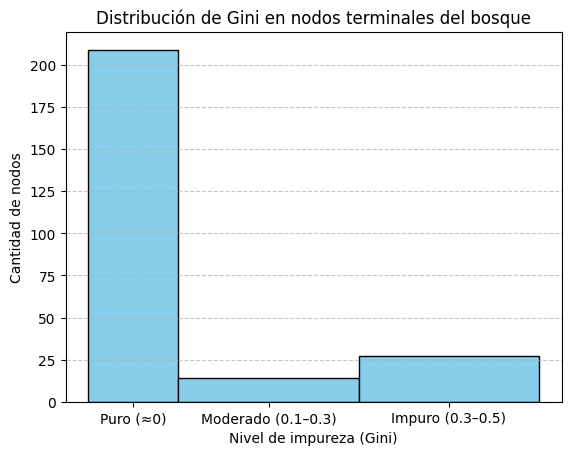

In [172]:
#Generar histogramas de frequencias
plt.hist(gini_last, bins=[0, 0.1, 0.3, 0.5], edgecolor='black', color='skyblue')
plt.xticks([0.05, 0.2, 0.4], ["Puro (≈0)", "Moderado (0.1–0.3)", "Impuro (0.3–0.5)"])
plt.title("Distribución de Gini en nodos terminales del bosque")
plt.xlabel("Nivel de impureza (Gini)")
plt.ylabel("Cantidad de nodos")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

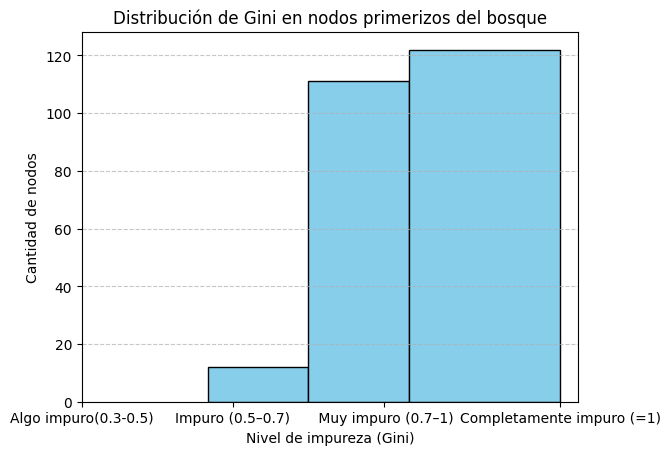

In [173]:
#Generar lo mismo pero con los primeros 
plt.hist(gini_first, bins=[0.3, 0.5, 0.7,1], edgecolor='black', color='skyblue')
plt.xticks([0.05, 0.35, 0.65, 1], ["Algo impuro(0.3-0.5)", "Impuro (0.5–0.7)", " Muy impuro (0.7–1)", "Completamente impuro (=1)"])
plt.title("Distribución de Gini en nodos primerizos del bosque")
plt.xlabel("Nivel de impureza (Gini)")
plt.ylabel("Cantidad de nodos")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()